Summary

This script provides a complete workflow for training a YOLOv10 model on a custom dataset, performing inference, and tracking objects in a video. The main steps include setting up the environment, downloading and preparing the dataset, training the model, and performing inference with tracking and annotation.
Index

* Setup and Installation (set up venv/install requirements.txt)
* Download YOLOv10 Weights
* Initialize YOLOv10 Model
* Download Dataset from Roboflow
* Inference with Pre-trained Model
* Custom Training
* Post-training Results and Visualization
* Download High-Quality Video from YouTube
* Object Tracking and Scoring

Best Links

* YOLOv10 GitHub Repository: [YOLOv10](https://github.com/THU-MIG/yolov10)
* Supervision Documentation: [Supervision](https://supervision.roboflow.com/how_to/track_objects/#__tabbed_2_1)
* Roboflow: [Roboflow](https://roboflow.com/)
* Albumentations: [Albumentations](https://albumentations.ai/)

In [138]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git
!pip install -q supervision roboflow


In [139]:
import os
import requests
import torch
from roboflow import Roboflow
from ultralytics import YOLOv10
import cv2
import supervision as sv
import yaml
import numpy as np
from pytube import YouTube
import shutil
from IPython.display import display, Image
import random


# Check GPU availability
print(torch.__version__)
print("CUDA available: ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Define directories
HOME = os.getcwd()
weights_dir = os.path.join(HOME, "weights")
os.makedirs(weights_dir, exist_ok=True)


2.3.1+cu121
CUDA available:  True
Using device: cuda


In [140]:

# URLs of the weights files
weights_urls = [
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt",
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10s.pt",
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10m.pt",
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10b.pt",
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10x.pt",
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10l.pt"
]

# Function to download files
def download_file(url, dest_folder):
    filename = os.path.join(dest_folder, url.split('/')[-1])
    if not os.path.exists(filename):
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"Downloaded: {filename}")
    else:
        print(f"File already exists: {filename}")

# Download weights
for url in weights_urls:
    download_file(url, weights_dir)


File already exists: c:\Users\ghadf\vscode_projects\venv_projects\Pytorch\YOLO_exploration\weights\yolov10n.pt
File already exists: c:\Users\ghadf\vscode_projects\venv_projects\Pytorch\YOLO_exploration\weights\yolov10s.pt
File already exists: c:\Users\ghadf\vscode_projects\venv_projects\Pytorch\YOLO_exploration\weights\yolov10m.pt
File already exists: c:\Users\ghadf\vscode_projects\venv_projects\Pytorch\YOLO_exploration\weights\yolov10b.pt
File already exists: c:\Users\ghadf\vscode_projects\venv_projects\Pytorch\YOLO_exploration\weights\yolov10x.pt
File already exists: c:\Users\ghadf\vscode_projects\venv_projects\Pytorch\YOLO_exploration\weights\yolov10l.pt


In [141]:

# Initialize YOLO model
model = YOLOv10(os.path.join(weights_dir, "yolov10n.pt"))
print("yolov10 preset classes = ",model.names)

# Download dataset from Roboflow
rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace("basketball-formations").project("basketball-and-hoop-7xk0h")
version = project.version(11)
dataset = version.download("yolov8")

# Update YAML file locations
dataset_location = dataset.location
data_yaml_path = os.path.join(dataset_location, "data.yaml")

# Load and modify YAML file
with open(data_yaml_path, 'r') as file:
    data_yaml = yaml.safe_load(file)
data_yaml['train'] = '../train/images'
data_yaml['val'] = '../valid/images'
with open(data_yaml_path, 'w') as file:
    yaml.safe_dump(data_yaml, file)

# Load class names from YAML file
class_names = data_yaml['names']
print("my roboflow classes = ", class_names)

yolov10 preset classes =  {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 41: '41', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48', 49: '49', 50: '50', 51: '51', 52: '52', 53: '53', 54: '54', 55: '55', 56: '56', 57: '57', 58: '58', 59: '59', 60: '60', 61: '61', 62: '62', 63: '63', 64: '64', 65: '65', 66: '66', 67: '67', 68: '68', 69: '69', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79'}
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`
my roboflow classes = 

In [142]:
# Inference with pre-trained model
image_path = os.path.join(HOME, "your_image.png")  # Replace with your image path
image = cv2.imread(image_path)
results = model(image)[0]
detections = sv.Detections.from_ultralytics(results)



0: 384x640 6 0s, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


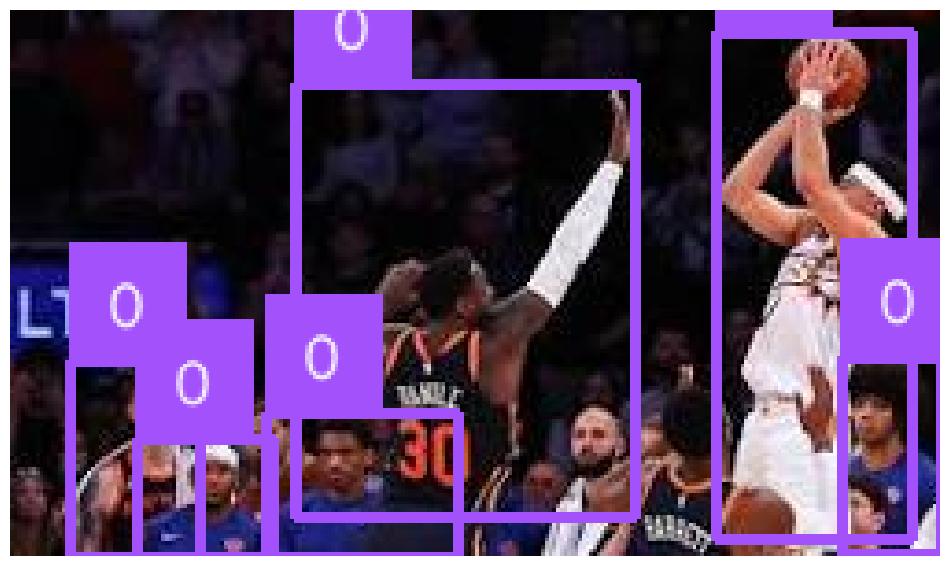

In [143]:
# Annotate and display image
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)
sv.plot_image(annotated_image)

In [159]:
# Remove previous run files if they exist
runs_dir = os.path.join(HOME, "runs")
if os.path.exists(runs_dir):
   shutil.rmtree(runs_dir)
   print(f"Removed previous run files in {runs_dir}")

# Custom training
os.system(f'yolo task=detect mode=train epochs=25 batch=8 plots=True model={os.path.join(weights_dir, "yolov10x.pt")} data={data_yaml_path} device={device}')


Removed previous run files in c:\Users\ghadf\vscode_projects\venv_projects\Pytorch\YOLO_exploration\runs


0

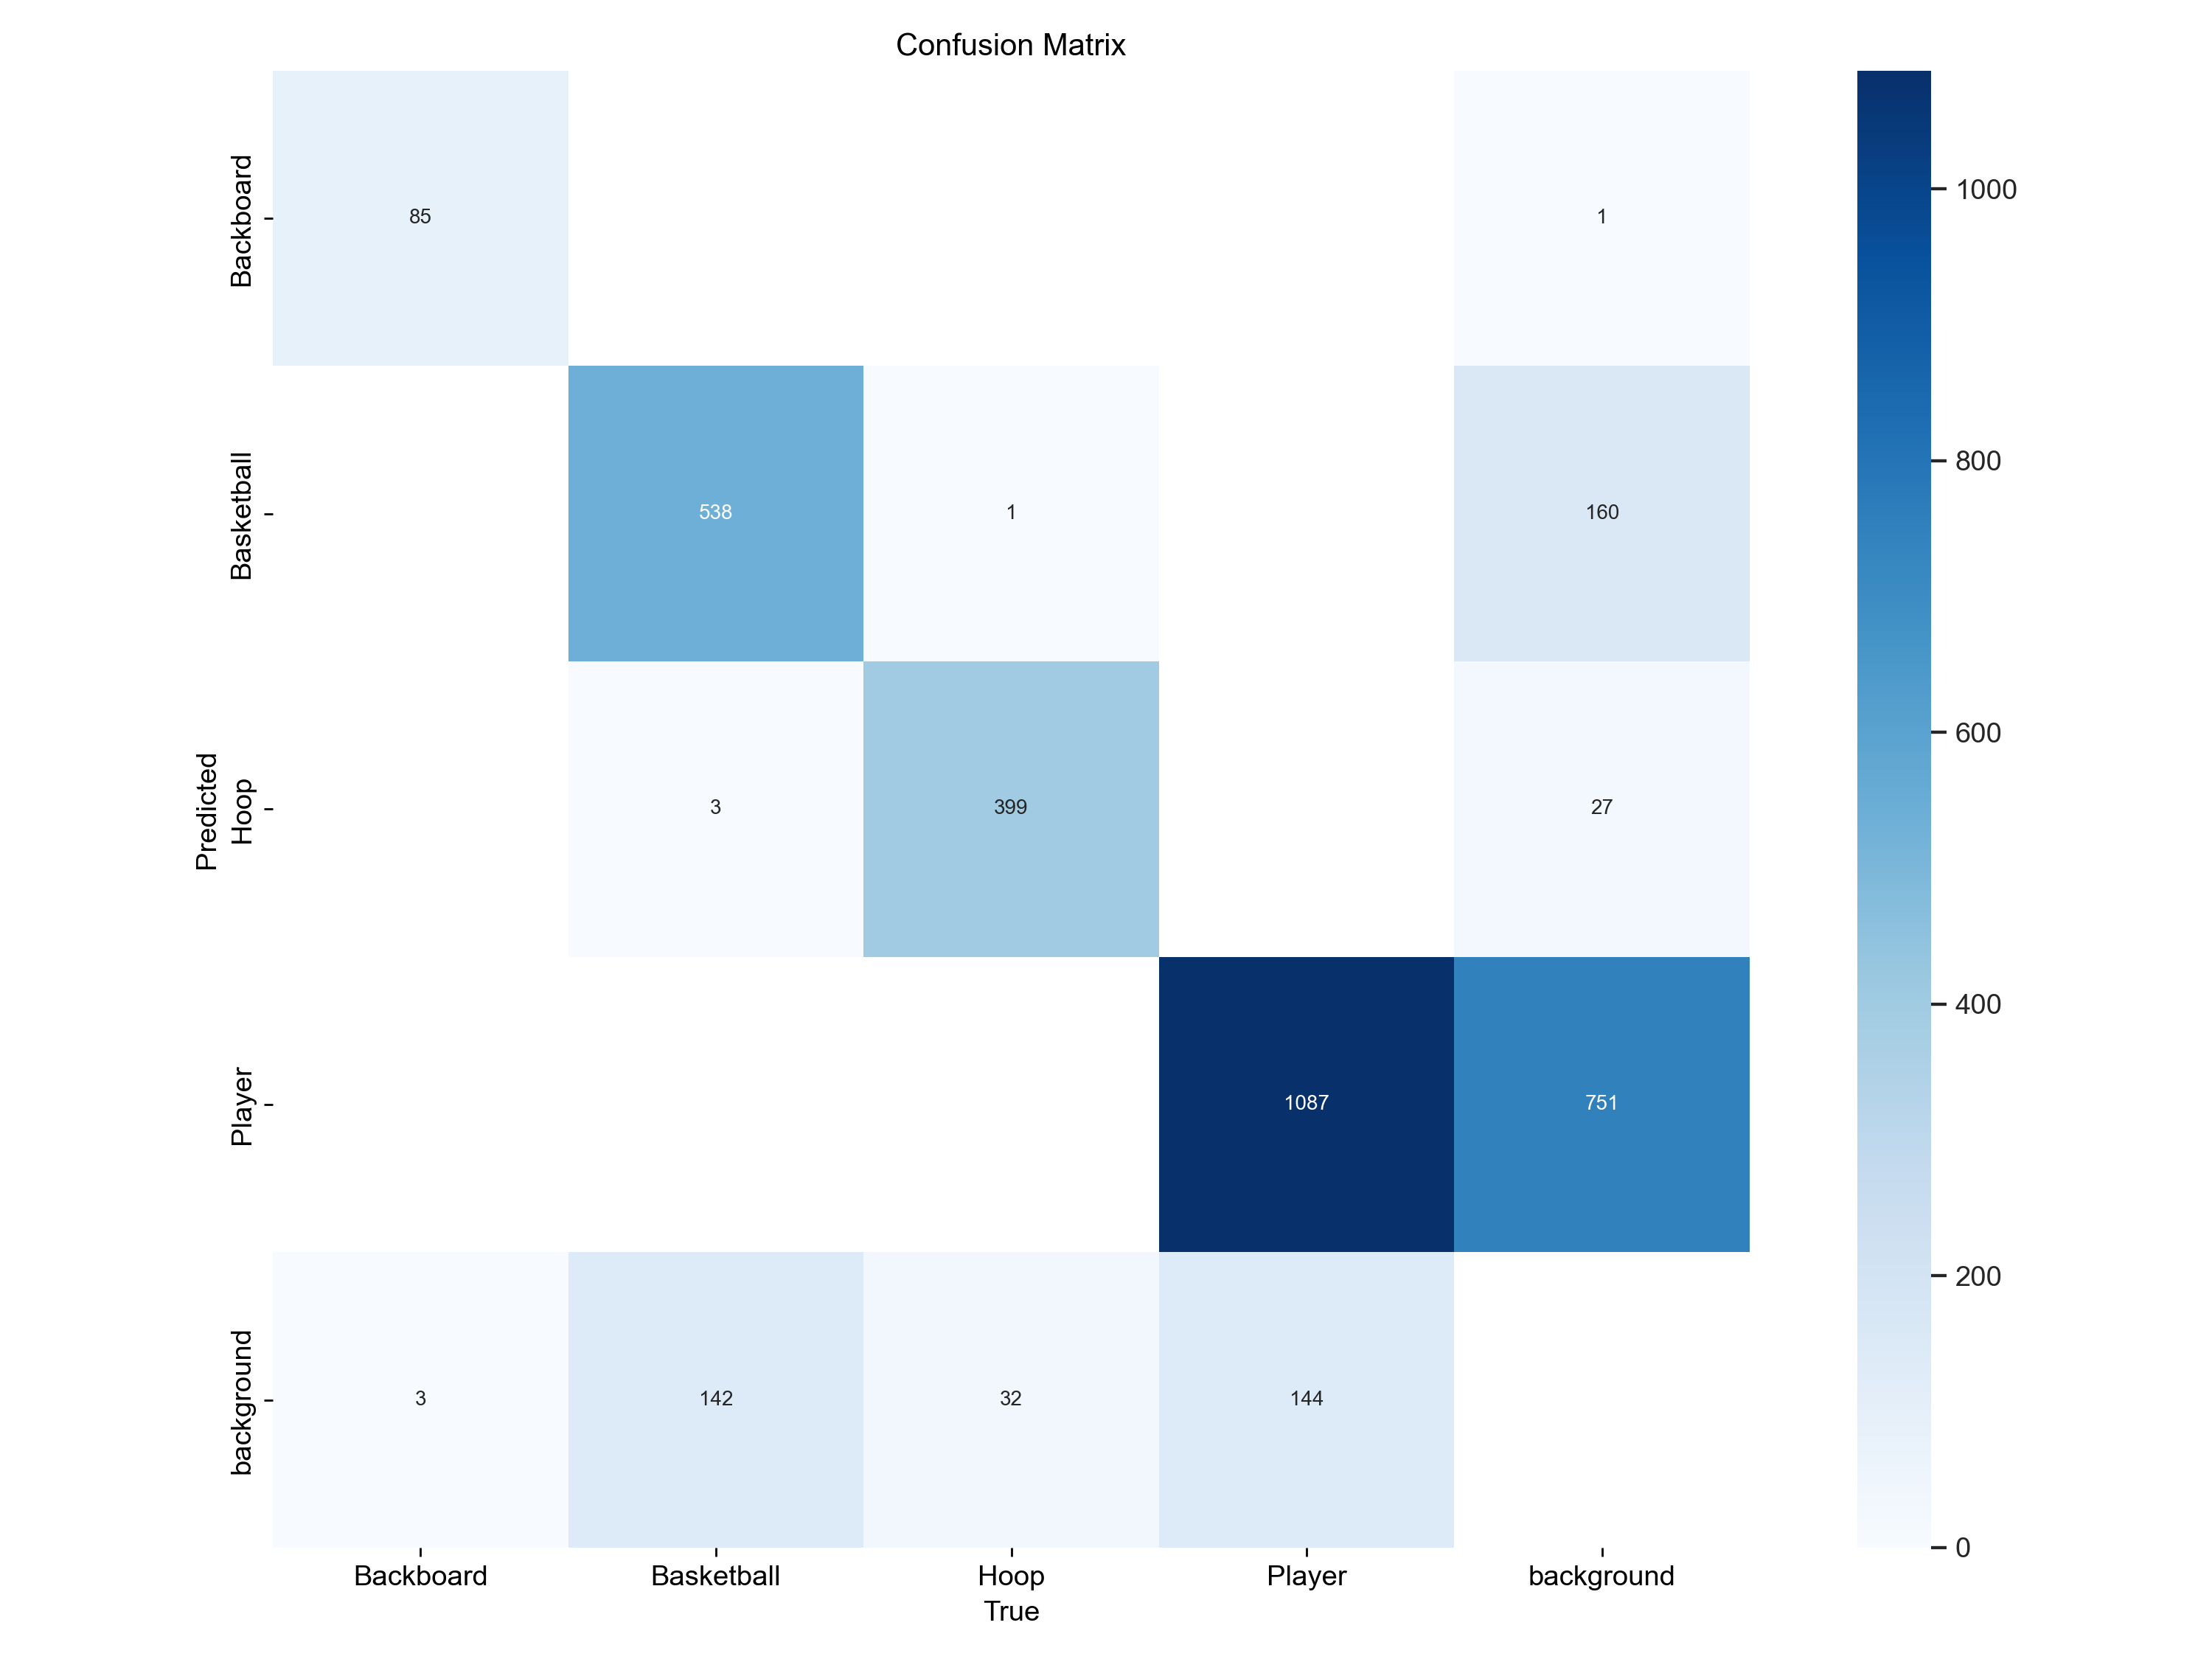

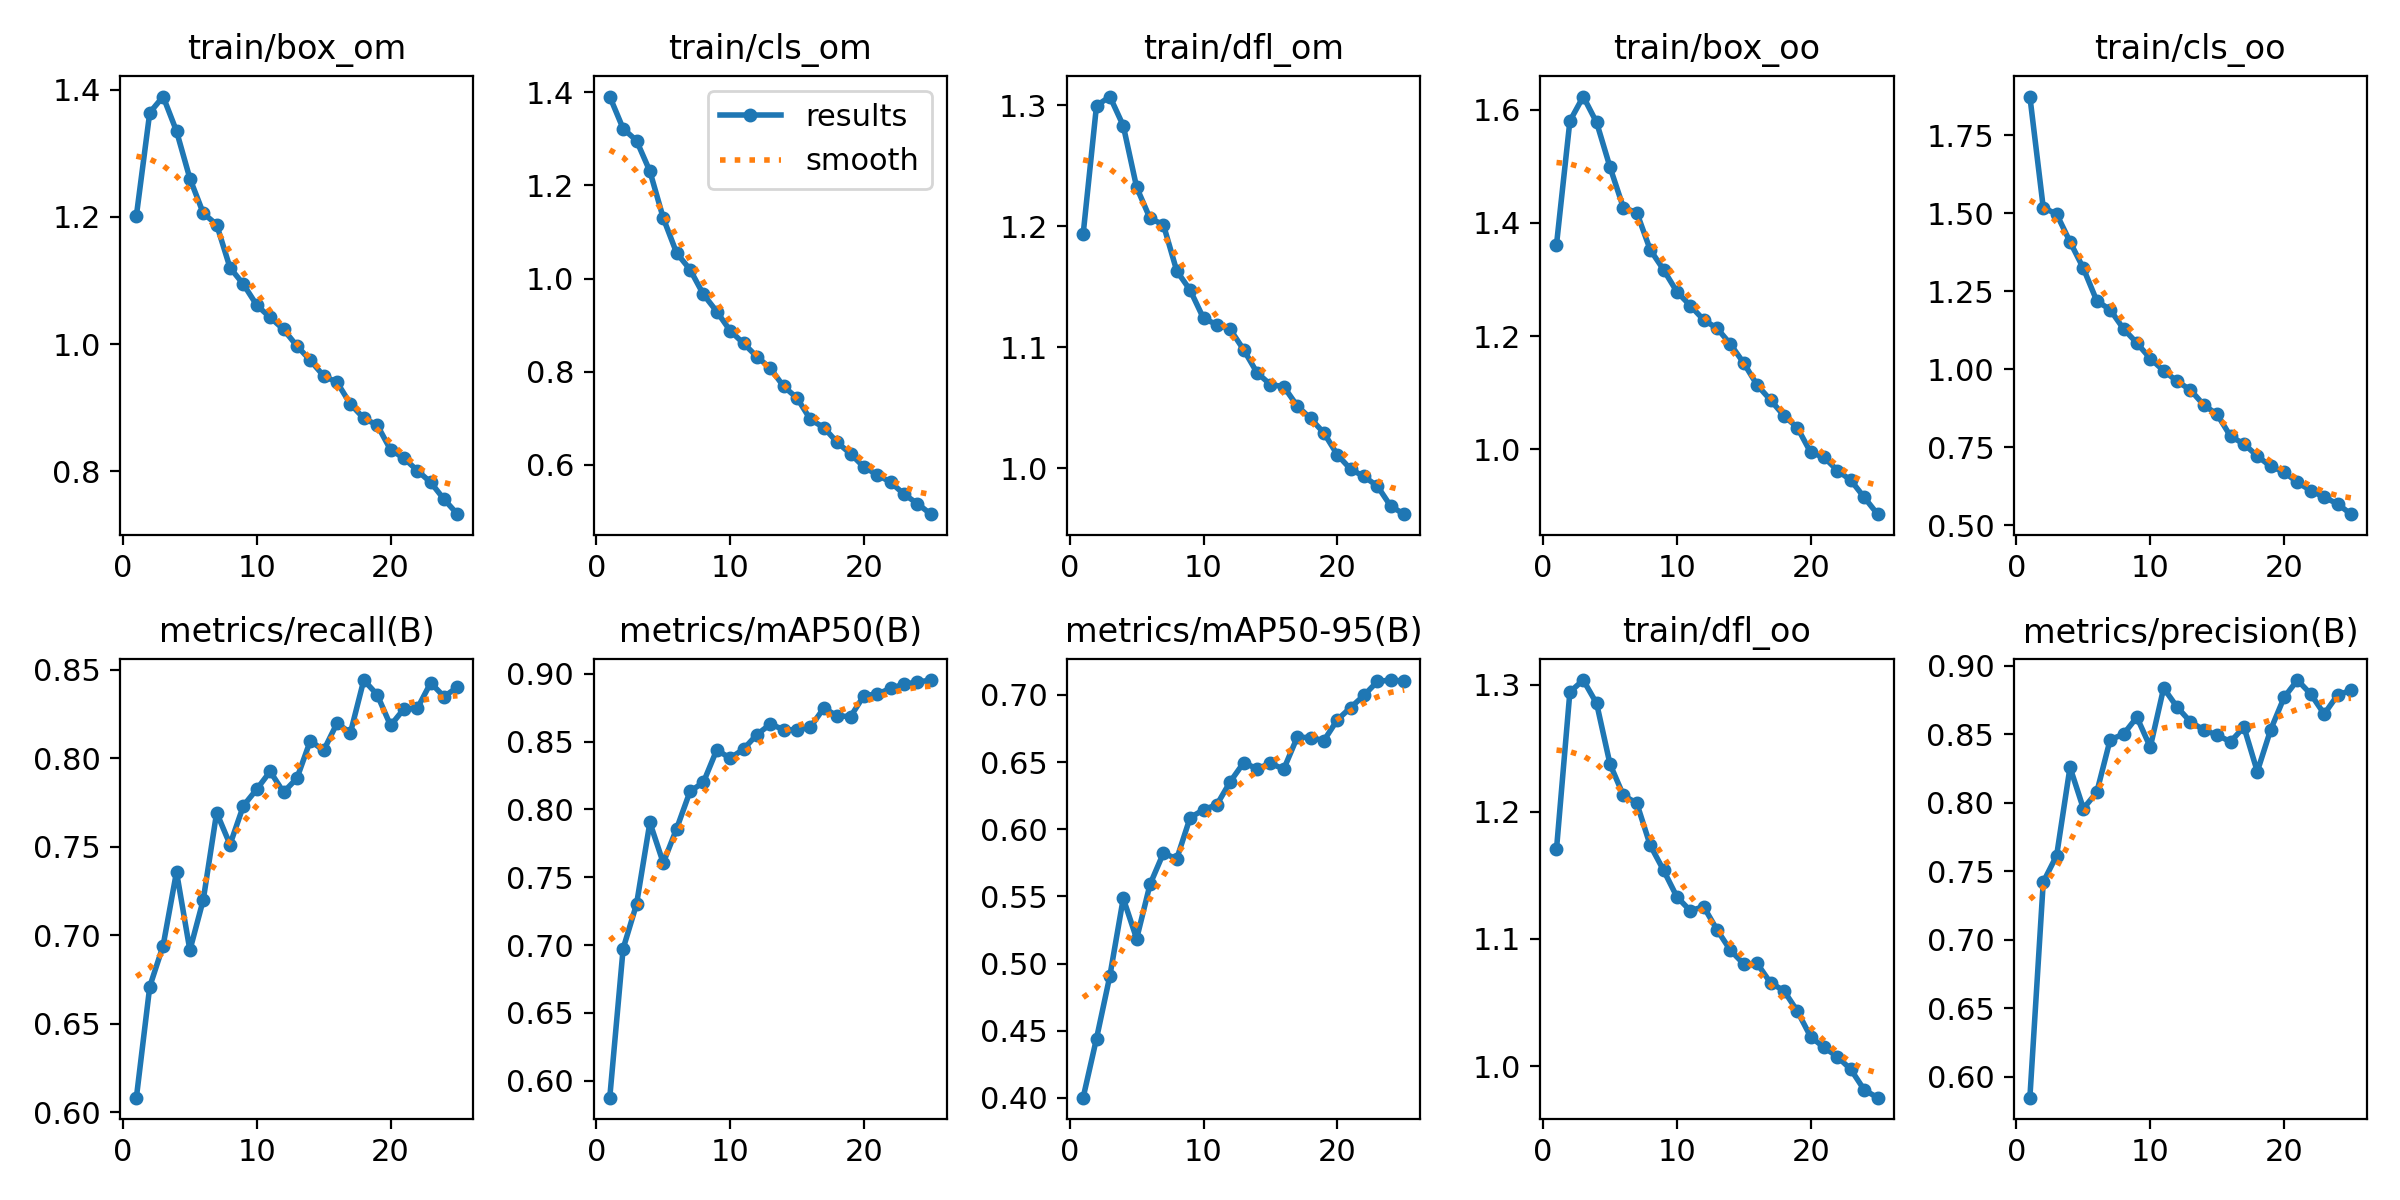

Trained model files:
best.pt
last.pt


In [160]:
# Post-training results
results_dir = os.path.join(HOME, "runs", "detect", "train")
best_model_path = os.path.join(results_dir, "weights", "best.pt")
if os.path.exists(results_dir):
    display(Image(filename=os.path.join(results_dir, "confusion_matrix.png"), width=600))
    display(Image(filename=os.path.join(results_dir, "results.png"), width=600))
    
    # Display model files
    print("Trained model files:")
    for file_name in os.listdir(os.path.join(results_dir, "weights")):
        if file_name.endswith(".pt"):
            print(file_name)


{0: 'Backboard', 1: 'Basketball', 2: 'Hoop', 3: 'Player'}

0: 640x640 1 Basketball, 1 Player, 51.0ms
Speed: 3.0ms preprocess, 51.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


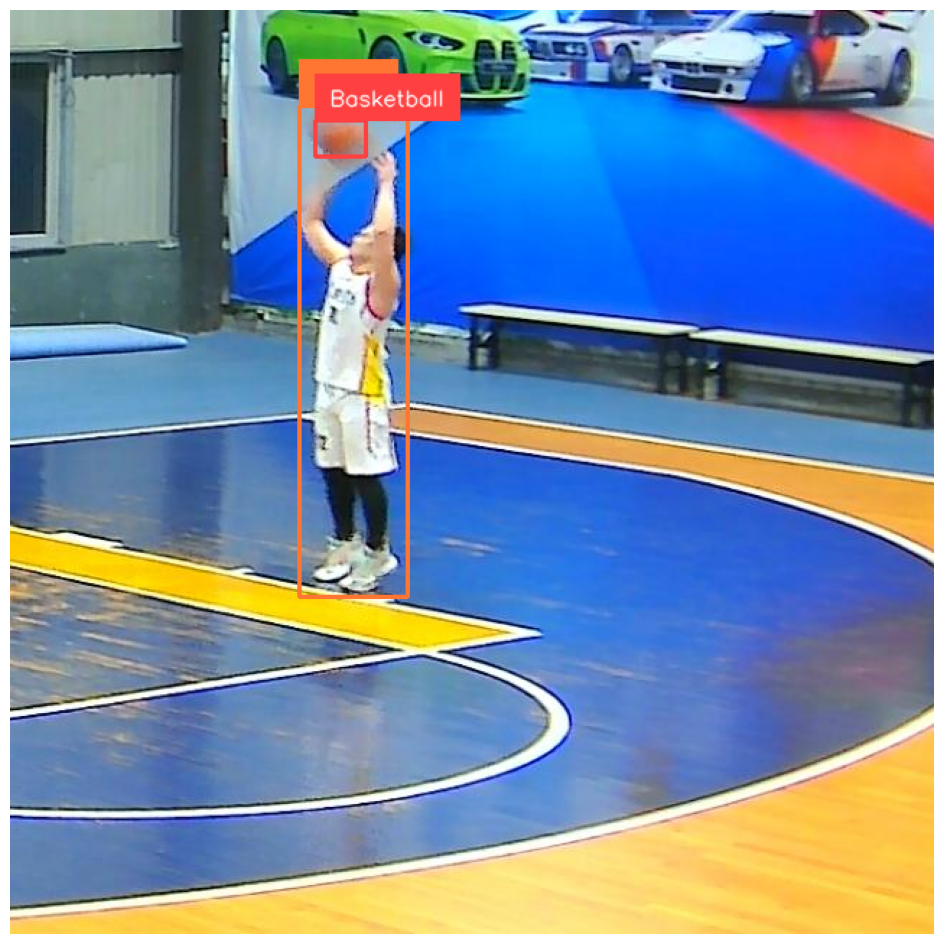

In [161]:
# %% Load the best trained model and visualize results
trained_model = YOLOv10(best_model_path)
print(trained_model.names)

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/valid/images",
    annotations_directory_path=f"{dataset_location}/valid/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Randomly select an image from the validation set and visualize the results
random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = trained_model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)
sv.plot_image(annotated_image)

In [174]:
import os
from pytube import YouTube
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import VideoFileClip

# Define the output directory
HOME = os.getcwd()
video_path = os.path.join(HOME, 'hq_luka.mp4')

# URL of the YouTube video
yt_video_url = 'https://www.youtube.com/watch?v=KyC6wr4I2VU'

# Create YouTube object
yt = YouTube(yt_video_url)

# Print available streams
print("Available streams:")
for stream in yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution'):
    print(stream)

# Download the highest resolution available
stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
stream.download(output_path=HOME, filename='hq_luka.mp4')

print(f"Downloaded video: {video_path}")

#For taking edits of videos to process the model on:

# Load the video to get its duration
video = VideoFileClip(video_path)
duration = video.duration

# Cut the video to start from 2:54 (174 seconds)
start_time = 183  # 2 minutes and 54 seconds
output_path = os.path.join(HOME, 'hq_luka_cut.mp4')

ffmpeg_extract_subclip(video_path, start_time, duration, targetname=output_path)

print(f"Cut video saved to: {output_path}")


Available streams:
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">
Downloaded video: c:\Users\ghadf\vscode_projects\venv_projects\Pytorch\YOLO_exploration\hq_luka.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Cut video saved to: c:\Users\ghadf\vscode_projects\venv_projects\Pytorch\YOLO_exploration\hq_luka_cut.mp4


Using this article to include the tracking:

https://supervision.roboflow.com/how_to/track_objects/#__tabbed_2_1

Using traceannotator to add tracing and labeling to include id's for each class


In [175]:
video_path = os.path.join(HOME, 'hq_luka_cut.mp4')

# Initialize trackers and annotators
tracker = sv.ByteTrack()
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# Initialize score and intersection tracking
score = 0
intersected_basketballs = set()

# Function to check intersection
def check_intersection(basketball_box, hoop_box):
    x1_b, y1_b, x2_b, y2_b = basketball_box
    x1_h, y1_h, x2_h, y2_h = hoop_box
    
    # Check if the boxes intersect
    if x1_b < x2_h and x2_b > x1_h and y1_b < y2_h and y2_b > y1_h:
        return True
    return False

# Callback function for processing each frame
def callback(frame: np.ndarray, _: int) -> np.ndarray:
    global score, intersected_basketballs
    results = trained_model(frame)
    print("Results type:", type(results))
    print("Results:", results)
    
    # Extract results from the list
    results = results[0]
    
    # Convert the results to Detections
    detections = sv.Detections.from_ultralytics(results)
    
    # Update detections with tracker
    detections = tracker.update_with_detections(detections)
    
    # Generate labels
    labels = [
        f"#{tracker_id} {trained_model.names[class_id]}"
        for class_id, tracker_id in zip(detections.class_id, detections.tracker_id)
    ]
    
    # Ensure that labels list matches the number of detections
    if len(labels) != len(detections):
        print(f"Warning: Number of labels ({len(labels)}) does not match number of detections ({len(detections)})")
        return frame  # Return the original frame if there's a mismatch

    # Get bounding boxes and tracker IDs for basketball and hoop
    basketball_boxes = [(box, tracker_id) for box, class_id, tracker_id in zip(detections.xyxy, detections.class_id, detections.tracker_id) if class_id == 1]
    hoop_boxes = [(box, tracker_id) for box, class_id, tracker_id in zip(detections.xyxy, detections.class_id, detections.tracker_id) if class_id == 2]
    
    # Check for intersection and update score
    for basketball_box, basketball_id in basketball_boxes:
        for hoop_box, hoop_id in hoop_boxes:
            if check_intersection(basketball_box, hoop_box):
                if basketball_id not in intersected_basketballs:
                    score += 1
                    intersected_basketballs.add(basketball_id)

    # Annotate frame with bounding boxes and labels
    annotated_frame = bounding_box_annotator.annotate(frame.copy(), detections=detections)
    annotated_frame = label_annotator.annotate(annotated_frame, detections=detections, labels=labels)

    # Overlay the score on the frame
    cv2.putText(annotated_frame, f"Score: {score}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    
    return trace_annotator.annotate(annotated_frame, detections=detections)

# Process video with tracking and scoring using the updated callback
sv.process_video(source_path=video_path, target_path=os.path.join(HOME, 'result.mp4'), callback=callback)



0: 384x640 1 Basketball, 2 Players, 51.0ms
Speed: 3.5ms preprocess, 51.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results type: <class 'list'>
Results: [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Backboard', 1: 'Basketball', 2: 'Hoop', 3: 'Player'}
obb: None
orig_img: array([[[  2,   4,   6],
        [  2,   4,   6],
        [  2,   4,   6],
        ...,
        [172, 198,  24],
        [171, 194,  29],
        [171, 194,  29]],

       [[  2,   4,   6],
        [  2,   4,   6],
        [  2,   4,   6],
        ...,
        [172, 198,  24],
        [171, 194,  29],
        [171, 194,  29]],

       [[  2,   4,   6],
        [  2,   4,   6],
        [  2,   4,   6],
        ...,
        [168, 194,  27],
        [168, 190,  35],
        [166, 188,  33]],

       ...,

       [[137,  91,  51],
        [137,  91,  51],
        [138,  92,  52],
        ...,
    